# 2023-02-17 Gram-Schmidt


## Last time

* Projections
* Rotations
* Reflections

## Today

* Revisit projections, rotations, and reflections
* Constructing orthogonal bases
* QR factorization

In [1]:
using LinearAlgebra
using Plots
using Polynomials
default(linewidth=4, legendfontsize=12)

function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

vander (generic function with 2 methods)

# Polynomials can be orthogonal too!


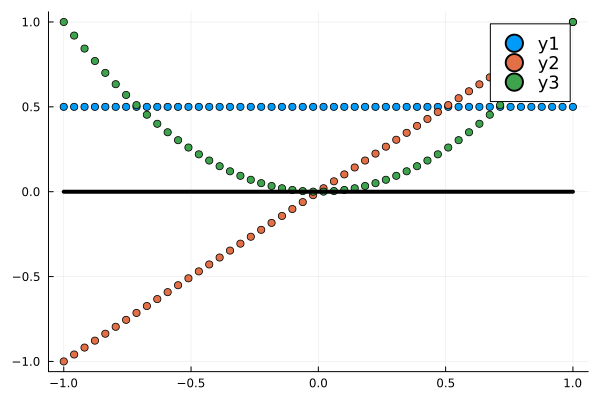

In [33]:
x = LinRange(-1, 1, 50)
A = vander(x, 4)
M = A * [.5 0 0 0; # 0.5
         0  1 0 0;  # x
         0  0 1 0]' # x^2
scatter(x, M)
plot!(x, 0*x, label=:none, color=:black)

* Which inner product will be zero?

  * Which functions are even and odd?

## Pairwise inner product
The pairwise inner products between two sets of vectors can be expressed by collecting the sets as columns in matrices and writing $A = X^T Y$ where $A_{i,j} = x_i^T y_j$.
It follows from this definition that
$$ (X^T Y)^T = Y^T X .$$

In [34]:
M' * M

3×3 Matrix{Float64}:
 12.5          -1.11022e-15   8.67347
 -1.11022e-15  17.3469       -2.22045e-16
  8.67347      -2.22045e-16  10.8272

# Normalization and orthogonalization

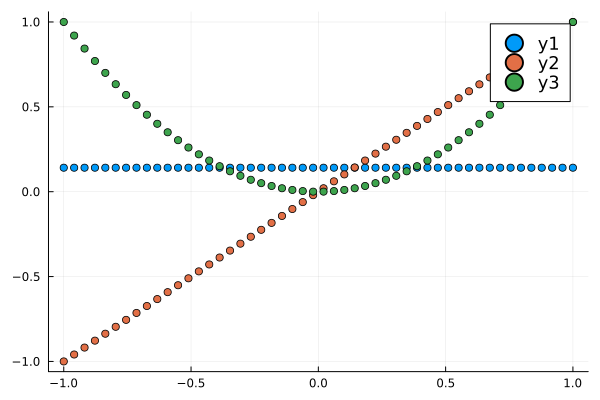

In [35]:
q1 = M[:,1]
q1 /= norm(q1) # normalize q1
Q = [q1 M[:, 2:end]]
scatter(x, Q)

In [36]:
Q' * Q

3×3 Matrix{Float64}:
  1.0          -1.94289e-16   2.45323
 -1.94289e-16  17.3469       -2.22045e-16
  2.45323      -2.22045e-16  10.8272

# Orthogonal matrices

If $x^T y = 0$ then we say $x$ and $y$ are **orthogonal** (or "$x$ is orthogonal to $y$").
A vector is said to be **normalized** if $\lVert x \rVert = 1$.
If $x$ is orthogonal to $y$ and $\lVert x \rVert = \lVert y \rVert = 1$ then we say $x$ and $y$ are **orthonormal**.
A square matrix with orthonormal columns is said to be an **orthogonal matrix**.
We typically use $Q$ or $U$ and $V$ for matrices that are known/constructed to be orthogonal.
Orthogonal matrices are always full rank -- the columns are linearly independent.
The inverse of a orthogonal matrix is its transpose:
$$ Q^T Q = Q Q^T = I . $$
Orthogonal matrices are a powerful building block for robust numerical algorithms.

# Gram-Schmidt orthogonalization

Suppose we're given some vectors and want to find an orthogonal basis for their span.

$$ \Bigg[ a_1 \Bigg| a_2 \Bigg] = \Bigg[ q_1 \Bigg| q_2 \Bigg] \begin{bmatrix} r_{11} & r_{12} \\ 0 & r_{22} \end{bmatrix} $$

# A naive algorithm

In [37]:
function gram_schmidt_naive(A)
    m, n = size(A)
    Q = zeros(m, n)
    R = zeros(n, n)
    for j in 1:n
        v = A[:,j]
        for k in 1:j-1
            r = Q[:,k]' * v
            v -= Q[:,k] * r
            R[k,j] = r
        end
        R[j,j] = norm(v)
        Q[:,j] = v / R[j,j]
    end
    Q, R
end

gram_schmidt_naive (generic function with 1 method)

In [38]:
A = vander(x, 4)
Q, R = gram_schmidt_naive(A)
@show norm(Q' * Q - I)
@show norm(Q * R - A);

norm(Q' * Q - I) = 6.609184312080184e-16
norm(Q * R - A) = 2.500206551829073e-16


# What do orthogonal polynomials look like?

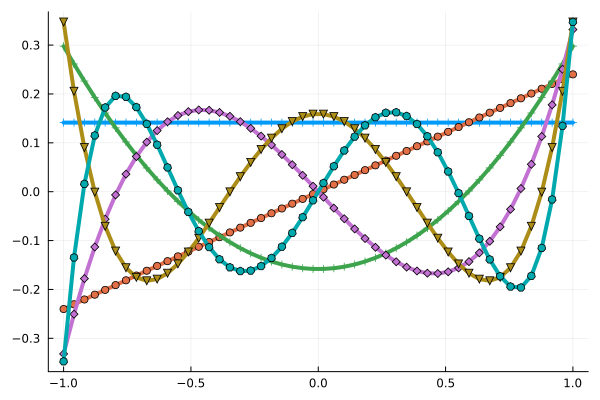

In [51]:
x = LinRange(-1, 1, 50)
A = vander(x, 6)
Q, R = gram_schmidt_naive(A)
plot(x, Q, marker=:auto, legend=:none)

What happens if we use more than 50 values of $x$? Is there a continuous limit?

# Theorem
## Every full-rank $m\times n$ matrix ($m \ge n$) has a unique reduced $Q R$ factorization with $R_{j,j} > 0$

The algorithm we're using generates this matrix due to the line:
```julia
        R[j,j] = norm(v)
```

# Solving equations using $QR = A$

If $A x = b$ then $Rx = Q^T b$.

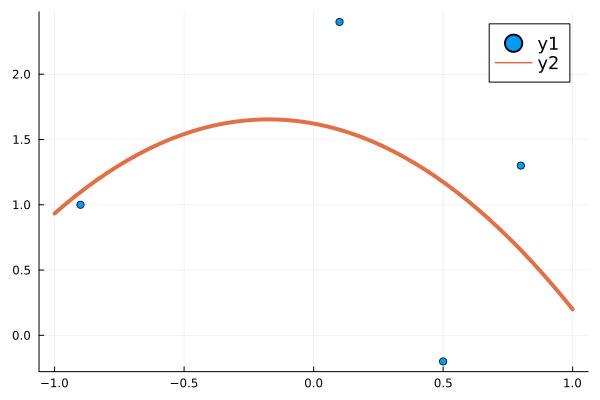

In [53]:
x1 = [-0.9, 0.1, 0.5, 0.8] # points where we know values
y1 = [1, 2.4, -0.2, 1.3]
scatter(x1, y1)
Q, R = gram_schmidt_naive(vander(x1, 3))
p = R \ (Q' * y1)
plot!(x, vander(x, 3) * p)

# How accurate is it?

In [56]:
m = 20
x = LinRange(-1, 1, m)
A = vander(x, m)
Q, R = gram_schmidt_naive(A)
@show norm(Q' * Q - I)
@show norm(Q * R - A)

norm(Q' * Q - I) = 1.073721107832196e-8
norm(Q * R - A) = 8.268821431611631e-16


8.268821431611631e-16

# A variant with more parallelism

$$ q_2 q_2^T (q_1 q_1^T v) = q_2 (q_2^T q_1) q_1^T v = 0 $$

In [57]:
function gram_schmidt_classical(A)
    m, n = size(A)
    Q = zeros(m, n)
    R = zeros(n, n)
    for j in 1:n
        v = A[:,j]
        R[1:j-1,j] = Q[:,1:j-1]' * v
        v -= Q[:,1:j-1] * R[1:j-1,j]
        R[j,j] = norm(v)
        Q[:,j] = v / norm(v)
    end
    Q, R
end

gram_schmidt_classical (generic function with 1 method)

In [60]:
m = 20
x = LinRange(-1, 1, m)
A = vander(x, m)
Q, R = gram_schmidt_classical(A)
@show norm(Q' * Q - I)
@show norm(Q * R - A)

norm(Q' * Q - I) = 1.4985231287367549
norm(Q * R - A) = 7.350692433565389e-16


7.350692433565389e-16